**Convolutional Neural Network using Mel Spectograms as features**

In this notebook, the Librosa library is used to extract Mel Spectrograms (frequency against time) for each of the audio samples. These spectrograms are used as features to train models including a convolutional neural network. Deep learning techniques like CNNs are well suited to take in unstructured data like spectrograms and find interesting patterns.

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import math, random, pickle, os, operator
from tempfile import TemporaryFile

from scipy.io import wavfile
from python_speech_features import mfcc
import librosa
import librosa.display

%matplotlib inline

In [2]:
## Use GPU support with Tensorflow
# needed to prevent error from using too much gpu memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


Load Data
- Will use Librosa library this time to find Mel Spectograms of each audio sample

In [3]:
#Example spectogram from blues audio file
t, rate = librosa.load("D:/Datasets/genres/blues/blues.00091.wav") # returns sample rate and data (sig)
spect = librosa.feature.melspectrogram(t, rate) # convert to melspectogram
spect.shape

(128, 1293)

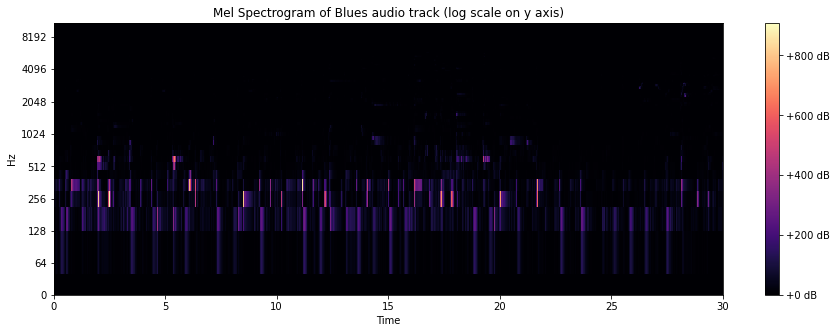

In [4]:
# Plotting Mel Spectrogram for an audio sample
def draw_specs(spects):
    for spect in spects:
        fig, ax = plt.subplots(figsize=(15,5))
        g = librosa.display.specshow(spect, x_axis='time', y_axis='log',ax=ax)
        ax.set(title="Mel Spectrogram of audio track (log scale on y axis)")
        fig.colorbar(g, ax=ax, format="%+2.f dB")

draw_specs([spect])

The genre of a song can usually be classified in much less than 30 seconds. Therefore, the audio samples can be split into samples of 3 seconds, resulting in 10 times the data.

In [29]:
# creating directories - only done once
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'
genres = genres.split()
# for g in genres:
#     path_audio = os.path.join('D:/Datasets/genres_3sec',f'{g}')
#     os.makedirs(path_audio)

In [30]:
# Audio segmentation into 3 second audio samples
from pydub import AudioSegment
i=0
for g in genres:
    j=0
    print(f"{g}")
    for filename in os.listdir(os.path.join('D:/Datasets/genres',f"{g}")):

        song  =  os.path.join(f'D:/Datasets/genres/{g}',f'{filename}')
        j = j+1
        for w in range(0,10):
            i = i+1
            #print(i)
            t1 = 3*(w)*1000
            t2 = 3*(w+1)*1000
            newAudio = AudioSegment.from_wav(song)
            new = newAudio[t1:t2]
            new.export(f'D:/Datasets/genres_3sec/{g}/{g+str(j)+str(w)}.wav', format="wav")

blues
classical
country
disco
hiphop
jazz
metal
pop
reggae
rock


In [31]:
# loading all audio samples and extracting mel spectrograms
path  = "D:/Datasets/genres_3sec/"
f = open("feat_spect.dat",'wb')

genre=0
for fold in os.listdir(path):
    genre+=1
    if genre==11:
        break
    for file in os.listdir(path+fold):
        # 29 second audio samples taken (length of shortest audio sample)
        t, rate = librosa.load(path+fold+"/"+file, duration=3) # returns sample rate and data (sig)
        spect = librosa.feature.melspectrogram(t, rate) # convert to melspectogram
        feature = (spect, genre)
        pickle.dump(feature, f)

f.close()

In [75]:
# loading data
dataset = []

with open("feat_spect.dat", 'rb') as f:
    while True:
        try:
            dataset.append(pickle.load(f))
        except EOFError:
            f.close()
            break





In [82]:
# Split dataset
X_train = []
y_train = []
X_test = []
y_test = []

# randomise dataset so that labels aren't just memorised when it encounters every example
# with the same label, and then just memorise the next label for the next set
random.shuffle(dataset)
for x in range(len(dataset)):
    if (dataset[x][0].shape!=(128,130)):
        print(f"Bad data at {x}")
        continue
    if random.random() < 0.9:
        X_train.append(dataset[x][0])
        y_train.append(dataset[x][1])
    else:
        X_test.append(dataset[x][0])
        y_test.append(dataset[x][1])

Bad data at 3492
Bad data at 5429
Bad data at 7427
Bad data at 8198


In [84]:
len(X_train)

8961

**Data Cleaning**

In [85]:
# Convert to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = to_categorical(np.array([y-1 for y in y_train]))
y_test = to_categorical(np.array([y-1 for y in y_test]))
# Reshape for CNN
X_train = X_train.reshape(X_train.shape[0], 128, X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], 128, X_train.shape[2], 1)
# normalise
X_train = X_train / 255.0
X_test = X_test / 255.0
# convert labels to categorical?

In [86]:
X_train.shape

(8961, 128, 130, 1)

In [87]:
len(dataset)

10000

In [88]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

**CNN**


In [115]:
model = Sequential([
    layers.InputLayer(input_shape=X_train.shape[1:]),

    # Data augmentation


    # Convolution
    
    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1)),
    BatchNormalization(axis=1),
    Activation("relu"),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=16, kernel_size=(3,3), strides=(1,1)),
    BatchNormalization(axis=1),
    Activation("relu"),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32, kernel_size=(3,3), strides=(1,1)),
    BatchNormalization(axis=1),
    Activation("relu"),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=64, kernel_size=(3,3), strides=(1,1)),
    BatchNormalization(axis=1),
    Activation("relu"),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=128, kernel_size=(3,3), strides=(1,1)),
    BatchNormalization(axis=1),
    Activation("relu"),
    MaxPooling2D(pool_size=(2,2)),

    # BatchNormalization(renorm=True),
    # Conv2D(filters=128, kernel_size=3, activation='relu',padding='same'),
    # Dropout(0.1),
    # MaxPooling2D(pool_size=(2,2)),

    Flatten(),

    Dropout(0.3),

    Dense(10,activation='softmax'),

])

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_split = 0.2)

Epoch 1/30
224/224 [==============================] - 4s 15ms/step - loss: 2.3346 - accuracy: 0.1768 - val_loss: 2.8096 - val_accuracy: 0.1110
Epoch 2/30
224/224 [==============================] - 3s 14ms/step - loss: 1.6976 - accuracy: 0.3806 - val_loss: 1.7114 - val_accuracy: 0.3938
Epoch 3/30
224/224 [==============================] - 3s 14ms/step - loss: 1.4079 - accuracy: 0.4865 - val_loss: 1.2342 - val_accuracy: 0.5666
Epoch 4/30
224/224 [==============================] - 3s 14ms/step - loss: 1.2026 - accuracy: 0.5871 - val_loss: 1.1703 - val_accuracy: 0.5845
Epoch 5/30
224/224 [==============================] - 3s 14ms/step - loss: 1.0896 - accuracy: 0.6281 - val_loss: 0.9661 - val_accuracy: 0.6548
Epoch 6/30
224/224 [==============================] - 3s 14ms/step - loss: 0.9706 - accuracy: 0.6630 - val_loss: 1.2157 - val_accuracy: 0.5856
Epoch 7/30
224/224 [==============================] - 3s 14ms/step - loss: 0.8792 - accuracy: 0.6986 - val_loss: 1.2172 - val_accuracy: 0.6129

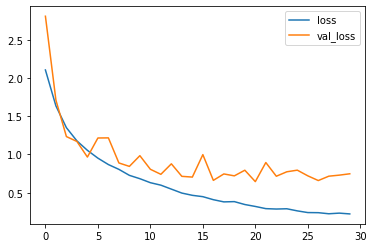

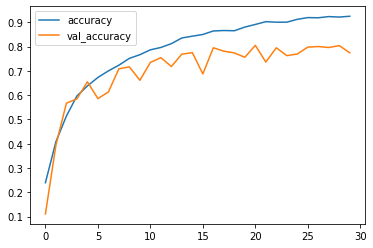

In [116]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

Overfitting Problem:
- Accuracy on training set is very good (96%), while validation accuracy (calculated on subset of data not used for training) is very low (37%)
- This is called overfitting as the training set is almost being memorised and it is not finding the general patterns in the features that allow the model to generalise well to previously unseen data.

Steps to solve overfitting:
- Randomize data
    - needed to randomize the order of labels, so that it doesn't just memorise one label, and then memorise the next one (overfitting)
- Reduce number of features as there are only 1000 training examples
    - Time of audio sample shortened to 5 seconds - resulted in slightly improved validation accuracy
    - More training examples added later on (to around 10000 audio samples)
- Apply dropout layers
    - 
- Reduce complexity of CNN
- Add more training examples
    - Splitting the audio samples into 3 second segments resulted in a 10-fold increase in data, and validation accuracy grew to 57%


Adding convolutional layers with increasing number of filters improved the performance
- 3 CNN layers with filters 8,16,32 has accuracy of 64% after 10 epochs
- Adding more CNN layers helped the model pick out more complex features of the spectrograms
    - Initially it just had 1 convolutional layer which picked out simple features and the model was overfitting
- Max number of filters in convolutional layer is 128
    - Convolutional layers were added starting with 8 filters and going up in powers of 2 to 128.
    - This helps the model find more complex features and the number of filters increases as the pooling layers tends to decrease the size of the data


Got to 80% accuracy


In [117]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 126, 128, 8)       80        
_________________________________________________________________
batch_normalization_58 (Batc (None, 126, 128, 8)       504       
_________________________________________________________________
activation_59 (Activation)   (None, 126, 128, 8)       0         
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 63, 64, 8)         0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 61, 62, 16)        1168      
_________________________________________________________________
batch_normalization_59 (Batc (None, 61, 62, 16)        244       
_________________________________________________________________
activation_60 (Activation)   (None, 61, 62, 16)      